# Pandas vs. Polars Performance Comparison

## Introduction: Pandas and Polars

**Pandas** is a widely used Python library for data analysis and manipulation. It is built on NumPy and is known for its flexible data structures, particularly the DataFrame. Pandas has been a cornerstone in the Python data science ecosystem for many years.

**Polars** is a data manipulation library written in Rust, with APIs available for Python, Node.js, and other languages. It is designed for high performance, especially on large datasets, by leveraging parallelism and efficient query execution.

## Why Compare Performance?

Choosing the right data manipulation library can significantly impact the performance of applications, especially when working with large volumes of data. A performance comparison between Pandas and Polars is useful to:

*   Identify which library is faster for specific operations.
*   Understand the strengths and weaknesses of each library in different scenarios.
*   Make informed decisions about selecting the most suitable library for a given project or task, considering factors like dataset size, types of operations, and performance requirements.

## Tests Performed and Methodology

This performance comparison was conducted on a randomly generated dataset of 10 million rows with the following columns: `id`, `category`, `value`, `amount`, and `date`.

The following tests were performed to compare the performance of Pandas and Polars:

1.  **I/O Read/Write:** Measuring the time taken to read and write data in CSV and Parquet formats.
2.  **Groupby Operations:** Comparing performance in executing aggregations on grouped data.
3.  **Filtering:** Measuring the speed of filtering data based on multiple conditions.
4.  **Sorting:** Comparing the time required to sort the dataset by one or more columns.
5.  **Join:** Measuring performance in joining the main dataset with a small lookup table.
6.  **Pipeline:** Evaluating the performance of executing a sequence of common operations (filtering, groupby, aggregation, and sorting) in a pipeline.

For each test, the operation was executed multiple times (10 times in this case), and the average execution time was recorded to provide a more reliable measure of performance.

The results are summarized in a table and visualized in a bar chart for easy interpretation.

## Summary of Results

The performance comparison tests conducted on a 10 million row dataset show that Polars generally outperforms Pandas across various common data manipulation operations.

As seen from the results, Polars demonstrates significant speedups, particularly in I/O operations (reading CSV and Parquet), Joining data, and executing a data processing Pipeline. While the performance difference might be less pronounced in simpler operations like GroupBy and Filter on this specific dataset, the overall trend indicates Polars' efficiency.

## Why is Polars Faster?

Polars' performance advantages over Pandas stem from several key architectural design choices:

1.  **Native Parallelization:** Polars is built from the ground up to leverage multi-core processors, executing many operations in parallel automatically. Pandas, in contrast, is largely single-threaded for core operations.
2.  **Lazy Evaluation:** Polars uses lazy evaluation, allowing it to optimize the entire query plan before execution, reducing unnecessary computations and memory usage. Pandas uses eager execution, processing each step immediately.
3.  **Memory Efficiency:** Written in Rust, Polars is highly memory-efficient, utilizing optimized data structures and memory allocation strategies that are crucial for handling large datasets that may not fit entirely in RAM.
4.  **Optimized Query Engine:** Polars features a sophisticated query engine that can optimize and reorder operations for faster execution, for example, by pushing down filters.

These factors combine to make Polars a compelling choice for performance-critical data manipulation tasks, especially when dealing with large volumes of data.

## Import libraries

In [123]:
import pandas as pd
import polars as pl
import numpy as np
import time
import matplotlib.pyplot as plt

## Dataset generation

In [124]:
# Generate 10M rows dataset
def generate_data():
    np.random.seed(42)
    n = 10_000_000
    data = {
        'id': range(n),
        'category': np.random.choice(['A', 'B', 'C', 'D', 'E'], n),
        'value': np.random.randn(n),
        'amount': np.random.randint(100, 10000, n),
    }
    return data

In [125]:
# measure the execution time of a function
def time_it(func, *args):
    start = time.perf_counter()
    result = func(*args)
    return time.perf_counter() - start, result

In [126]:
# Generate and save data
data = generate_data()
df_pd = pd.DataFrame(data)
df_pd.to_csv('test_10m.csv', index=False)
df_pd.to_parquet('test_10m.parquet')

In [127]:
# store the results
results = {}

## Input/Output tests

In [128]:
# pandas
for i in range(10):
  measures = []
  t, _ = time_it(pd.read_csv, 'test_10m.csv')
  measures.append(t)

input_mean_pd = np.mean(measures)
results['CSV Read Pandas'] = input_mean_pd
print(f"Pandas read CSV: {input_mean_pd:.2f}s")

Pandas read CSV: 4.53s


In [129]:
# polars
for i in range(10):
  measures = []
  t, _ = time_it(pl.read_csv, 'test_10m.csv')
  measures.append(t)

input_mean_pl = np.mean(measures)
results['CSV Read Polars'] = input_mean_pl
print(f"Polars read CSV: {input_mean_pl:.2f}s")

Polars read CSV: 2.57s


In [130]:
# pandas
for i in range(10):
  measures = []
  t, _ = time_it(pd.read_parquet, 'test_10m.parquet')
  measures.append(t)

input_mean_pd = np.mean(measures)
results['Parquet Read Pandas'] = input_mean_pd
print(f"Pandas read Parquet: {input_mean_pd:.2f}s")

Pandas read Parquet: 0.77s


In [131]:
# polars
for i in range(10):
  measures = []
  t, _ = time_it(pl.read_parquet, 'test_10m.parquet')
  measures.append(t)

input_mean_pl = np.mean(measures)
results['Parquet Read Polars'] = input_mean_pl
print(f"Polars read Parquet: {input_mean_pl:.2f}s")

Polars read Parquet: 0.58s


## Groupby tests

In [132]:
# Use parquet for speed
df_pd = pd.read_parquet('test_10m.parquet')
df_pl = pl.read_parquet('test_10m.parquet')

In [133]:
# pandas
for i in range(10):
  measures = []
  t, _ = time_it(lambda df: df.groupby('category').agg({'value': ['mean', 'sum'], 'amount': ['count', 'std']}), df_pd)
  measures.append(t)

input_mean_pd = np.mean(measures)
results['GroupBy Pandas'] = input_mean_pd
print(f"Pandas groupby: {input_mean_pd:.2f}s")

Pandas groupby: 0.91s


In [134]:
# polars
for i in range(10):
  measures = []
  t, _ = time_it(lambda df: df.group_by('category').agg([
      pl.col('value').mean().alias('value_mean'),
      pl.col('value').sum().alias('value_sum'),
      pl.col('amount').count().alias('amount_count'),
      pl.col('amount').std().alias('amount_std')
  ]), df_pl)
  measures.append(t)

input_mean_pl = np.mean(measures)
results['GroupBy Polars'] = input_mean_pl
print(f"Polars groupby: {input_mean_pl:.2f}s")

Polars groupby: 0.84s


## Filtering tests

In [135]:
# pandas
for i in range(10):
  measures = []
  t, _ = time_it(lambda df: df[(df['value'] > 0) & (df['amount'] > 5000) & (df['category'].isin(['A', 'B']))], df_pd)
  measures.append(t)

input_mean_pd = np.mean(measures)
results['Filter Pandas'] = input_mean_pd
print(f"Pandas: {input_mean_pd:.2f}s")

Pandas: 0.43s


In [136]:
# polars
for i in range(10):
  measures = []
  t, _ = time_it(lambda df: df.filter((pl.col('value') > 0) & (pl.col('amount') > 5000) & pl.col('category').is_in(['A', 'B'])), df_pl)
  measures.append(t)

input_mean_pl = np.mean(measures)
results['Filter Polars'] = input_mean_pl
print(f"Polars: {input_mean_pl:.2f}s")

Polars: 0.31s


## Sorting tests

In [137]:
# pandas
for i in range(10):
  measures = []
  t, _ = time_it(lambda df: df.sort_values(['category', 'value'], ascending=[True, False]), df_pd)
  measures.append(t)

input_mean_pd = np.mean(measures)
results['Sort Pandas'] = input_mean_pd
print(f"Pandas: {input_mean_pd:.2f}s")

Pandas: 13.67s


In [138]:
# polars
for i in range(10):
  measures = []
  t, _ = time_it(lambda df: df.sort(['category', 'value'], descending=[False, True]), df_pl)
  measures.append(t)

input_mean_pl = np.mean(measures)
results['Sort Polars'] = input_mean_pl
print(f"Polars: {input_mean_pl:.2f}s")

Polars: 13.17s


## Join tests

In [139]:
# pandas
lookup_pd = pd.DataFrame({'category': ['A', 'B', 'C', 'D', 'E'], 'weight': [1.0, 1.5, 2.0, 2.5, 3.0]})
for i in range(10):
  measures = []
  t, _ = time_it(lambda df: df.merge(lookup_pd, on='category'), df_pd)
  measures.append(t)

input_mean_pd = np.mean(measures)
results['Join Pandas'] = input_mean_pd
print(f"Pandas: {input_mean_pd:.2f}s")

Pandas: 2.19s


In [140]:
# polars
lookup_pl = pl.DataFrame(lookup_pd)
for i in range(10):
  measures = []
  t, _ = time_it(lambda df: df.join(lookup_pl, on='category'), df_pl)
  measures.append(t)

input_mean_pl = np.mean(measures)
results['Join Polars'] = input_mean_pl
print(f"Polars: {input_mean_pl:.2f}s")

Polars: 0.80s


## Pipeline test

In [141]:
def pandas_pipeline(df):
    return (df
            .query('value > 0 and amount > 1000')
            .groupby('category')['amount'].sum()
            .sort_values(ascending=False))

In [142]:
def polars_pipeline(df):
    return (df
            .filter((pl.col('value') > 0) & (pl.col('amount') > 1000))
            .group_by('category')
            .agg(pl.col('amount').sum())
            .sort('amount', descending=True))

In [143]:
# pandas
for i in range(10):
  measures = []
  t, _ = time_it(pandas_pipeline, df_pd)
  measures.append(t)

input_mean_pd = np.mean(measures)
results['Pipeline Pandas'] = input_mean_pd
print(f"Pandas: {input_mean_pd:.2f}s")

Pandas: 0.64s


In [144]:
# polars
for i in range(10):
  measures = []
  t, _ = time_it(polars_pipeline, df_pl)
  measures.append(t)

input_mean_pl = np.mean(measures)
results['Pipeline Polars'] = input_mean_pl
print(f"Polars: {input_mean_pl:.2f}s")

Polars: 0.34s


## Summary

In [158]:
for test in ['CSV Read', 'Parquet Read', 'GroupBy', 'Filter', 'Sort', 'Join', 'Pipeline']:
    pd_time = results[f'{test} Pandas']
    pl_time = results[f'{test} Polars']
    speedup = ((pd_time-pl_time)/pd_time)*100
    print(f"{test:12} | Pandas: {pd_time:5.2f}s | Polars: {pl_time:5.2f}s | Speedup: {speedup:5.2f}%")

CSV Read     | Pandas:  4.53s | Polars:  2.57s | Speedup: 43.36%
Parquet Read | Pandas:  0.77s | Polars:  0.58s | Speedup: 24.72%
GroupBy      | Pandas:  0.91s | Polars:  0.84s | Speedup:  7.04%
Filter       | Pandas:  0.43s | Polars:  0.31s | Speedup: 26.78%
Sort         | Pandas: 13.67s | Polars: 13.17s | Speedup:  3.65%
Join         | Pandas:  2.19s | Polars:  0.80s | Speedup: 63.21%
Pipeline     | Pandas:  0.64s | Polars:  0.34s | Speedup: 46.22%


## Plot summary

In [ ]:
# Prepare data for plotting
tests = list(results.keys())
pandas_times = [results[test] for test in tests if 'Pandas' in test]
polars_times = [results[test] for test in tests if 'Polars' in test]
test_labels = [test.replace(' Pandas', '').replace(' Polars', '') for test in tests if 'Pandas' in test]

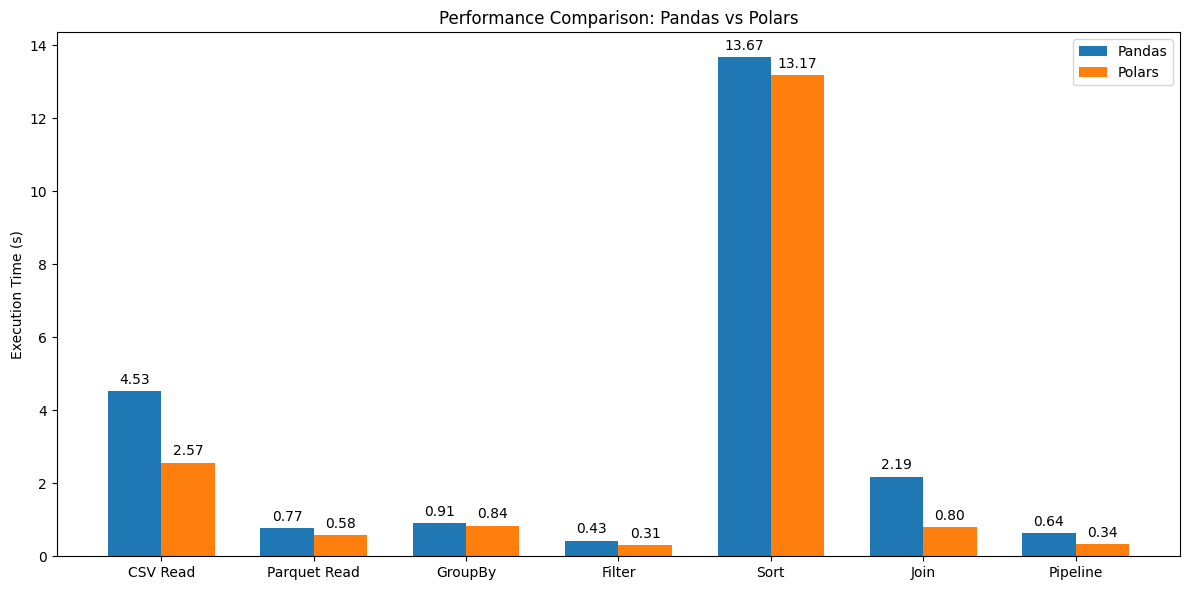

In [148]:
x = np.arange(len(test_labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, pandas_times, width, label='Pandas')
rects2 = ax.bar(x + width/2, polars_times, width, label='Polars')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Execution Time (s)')
ax.set_title('Performance Comparison: Pandas vs Polars')
ax.set_xticks(x)
ax.set_xticklabels(test_labels)
ax.legend()

# Add the values on top of the bars
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()